<a href="https://colab.research.google.com/github/superchd/AI-python-connect/blob/master/FMA_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# Cell 1) Install & Imports
# ============================================================
!pip -q install scikit-learn==1.5.2 xgboost==2.1.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

from xgboost import XGBRegressor

import re
import io
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
# ============================================================
# Cell 2) Load Excel from Google Drive (instead of manual upload)
#  - Make sure the file is in your Google Drive (e.g., MyDrive)
#  - File base name you mentioned: "KoreanCohort"
# ============================================================

!pip -q install openpyxl  # ensure Excel engine is available

from google.colab import drive
drive.mount('/content/drive')  # authorize access

import os, glob, io
import pandas as pd

# ---- Settings you can tweak ----
BASE_NAME = "KoreanCohort"     # the name you gave (without extension is fine)
SEARCH_ROOT = "/content/drive/MyDrive"  # where to search; adjust if needed
SHEET_NAME = None              # set to a sheet name or index (e.g., 0) if needed

# ---- Try to locate the file automatically (xlsx/xls) ----
patterns = [
    os.path.join(SEARCH_ROOT, f"**/{BASE_NAME}.xlsx"),
    os.path.join(SEARCH_ROOT, f"**/{BASE_NAME}.xls"),
    os.path.join(SEARCH_ROOT, f"**/{BASE_NAME}*.xlsx"),
    os.path.join(SEARCH_ROOT, f"**/{BASE_NAME}*.xls"),
]
candidates = []
for pat in patterns:
    candidates.extend(glob.glob(pat, recursive=True))

if not candidates:
    raise FileNotFoundError(
        f"Could not find an Excel file named like '{BASE_NAME}.xlsx' under {SEARCH_ROOT}.\n"
        f"- Tip: Verify the file exists in Drive and the name matches.\n"
        f"- You can also set an explicit path to the file below."
    )

# If multiple candidates are found, pick the first by default (or choose one)
xlsx_path = sorted(candidates)[0]
print("✅ Found Excel file:", xlsx_path)

# ---- Read Excel (optionally with a specific sheet) ----
if SHEET_NAME is None:
    df_raw = pd.read_excel(xlsx_path)            # default = first sheet
else:
    df_raw = pd.read_excel(xlsx_path, sheet_name=SHEET_NAME)

print("✅ Loaded shape:", df_raw.shape)
display(df_raw.head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found Excel file: /content/drive/MyDrive/KoreanCohort.xlsx
✅ Loaded shape: (764, 74)


,Unnamed: 0,SUBJFUNO,SEX,BIRTHDAT,AGE,FIRST-EVER STROKE,DIAG,경과일1,FUSRBA_7D,FUSRBU_7D,...,FUHGDA_7D,FUHGDU_7D,FUHGEA_7D,FUHGEU_7D,FUCTA_7D,FUCTU_7D,FUCDA_7D,FUCDU_7D,FUCSA_7D,FUCSU_7D
0,1,R-6-0001,1,1956-10-31,66,Y,1,6.0,2.0,2.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
1,2,R-6-0002,2,1935-10-10,87,Y,1,5.0,2.0,2.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,3,R-6-0003,1,1934-03-20,89,Y,1,7.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,4,R-6-0004,1,1937-02-04,86,Y,2,7.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,R-6-0006,2,1927-08-16,95,Y,1,7.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ============================================================
# Merge multiple sheets in the SAME Excel file -> build FMA totals -> set mapping
#  - Expects sheets like: '7Dfirst', '3Month', '6Month', '12Month' (case-insensitive, partial match OK)
#  - Uses SUBJFUNO as the unique ID
#  - Creates FMA_TOTAL_7D/3M/6M/12M from affected-side items (ending with 'A_<TP>')
#  - Produces 'df_raw' with totals, and 'colmap' for downstream modeling
# ============================================================

import re
import pandas as pd

# 0) Point to the SAME Excel file you already loaded in Cell 2
excel_path = xlsx_path  # keep this from your previous Drive-loading cell

# 1) Define timepoints and candidate sheet names
TP_SHEETS = {
    "7D":  ["7dfirst", "7d", "7 day", "day7", "first7", "7 d"],
    "3M":  ["3month", "3 m", "month3", "m3", "90d", "90 d"],
    "6M":  ["6month", "6 m", "month6", "m6", "180d", "180 d"],
    "12M": ["12month","12 m","month12","m12","365d","1y","1 year","12 mon"]
}
KEEP_COLS = {"SUBJFUNO","AGE","SEX"}  # demographics to keep unsuffixed

# 2) Helper: find a sheet name for a given timepoint using fuzzy match
def find_sheet_name(xls, candidates):
    sheets = [s for s in xls.sheet_names]
    low_sheets = [s.lower() for s in sheets]
    for cand in candidates:
        cand = cand.lower()
        for i,ls in enumerate(low_sheets):
            if cand in ls:
                return sheets[i]
    return None

# 3) Load per-sheet frame and normalize headers
def load_tp_sheet(path, sheet, tp):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = [str(c) for c in df.columns]
    if "SUBJFUNO" not in df.columns:
        raise ValueError(f"SUBJFUNO not found in sheet '{sheet}'")

    # Suffix item columns with _<TP> if not already suffixed; keep ID/AGE/SEX as-is
    def rename_col(c):
        if c in KEEP_COLS:
            return c
        # Already like ...A_<TP> or ...U_<TP>
        if re.search(rf"_[AU]_{tp}$", c, flags=re.IGNORECASE):
            return c
        # If looks like an item code (letters/digits + optional A/U), append _<TP>
        if re.match(r"^[A-Za-z0-9]+[AU]?$", c):
            return f"{c}_{tp}"
        return c

    df = df.rename(columns=rename_col)
    # Keep ID/AGE/SEX + columns for this TP only
    keep = [c for c in df.columns if (c in KEEP_COLS) or c.endswith(f"_{tp}")]
    return df[keep].copy()

# 4) Locate sheets inside the same Excel file
xls = pd.ExcelFile(excel_path)
sources = []
for tp, cand_list in TP_SHEETS.items():
    sh = find_sheet_name(xls, cand_list)
    if sh:
        sources.append({"tp": tp, "sheet": sh})
    else:
        print(f"⚠️ Sheet for {tp} not found. (candidates tried: {cand_list})")

if not sources:
    raise ValueError("No timepoint sheets were found in this Excel file. "
                     "Rename sheets or update TP_SHEETS to match your names.")

print("✅ Using sheets:")
for s in sources:
    print(f"  {s['tp']}: {s['sheet']}")

# 5) Merge sheets by SUBJFUNO

# ============================================================
# REPLACE THIS MERGE LOOP (fix duplicate AGE/SEX during merges)
# ============================================================

merged = None
present_tps = []

for idx, s in enumerate(sources):
    tp, sheet = s["tp"], s["sheet"]
    df_tp = load_tp_sheet(excel_path, sheet, tp)  # returns SUBJFUNO + AGE/SEX + items(_<TP>)

    if idx == 0:
        # Keep demographics only from the first sheet
        merged = df_tp.copy()
    else:
        # Drop demographics (except ID) from subsequent sheets to avoid duplicates
        drop_demo = [c for c in ["AGE", "SEX"] if c in df_tp.columns]
        df_tp_nodemo = df_tp.drop(columns=drop_demo, errors="ignore")
        merged = pd.merge(merged, df_tp_nodemo, on="SUBJFUNO", how="outer")

    present_tps.append(tp)
    print(f"✅ Merged {tp}: sheet '{sheet}'  -> shape {df_tp.shape}")

print("✅ Final merged shape:", merged.shape)
df_raw = merged.copy()
display(df_raw.head())


# 6) Build totals from affected-side items for each present TP
df_items = df_raw.copy()

def pick_affected_item_cols(columns, tp):
    # affected-side items end with 'A_<TP>' (e.g., FUSRBA_7D)
    pat = re.compile(rf"^[A-Za-z0-9]+A_{tp}$", re.IGNORECASE)
    return [c for c in columns if re.search(pat, str(c))]

built_totals = []
for tp in ["7D","3M","6M","12M"]:
    if tp not in present_tps:
        continue
    a_cols = pick_affected_item_cols(df_items.columns, tp)
    if not a_cols:
        print(f"⚠️ No affected-side items for {tp}")
        continue
    total_col = f"FMA_TOTAL_{tp}"
    df_items[total_col] = (
        df_items[a_cols].apply(pd.to_numeric, errors="coerce")
        .sum(axis=1, skipna=True)
        .clip(lower=0, upper=66)
    )
    built_totals.append(total_col)
    print(f"✅ Built {total_col} from {len(a_cols)} items")

print("🧮 Totals created:", built_totals)
display(df_items[[c for c in df_items.columns if c.startswith("FMA_TOTAL_")]].head())

# 7) Fixed mapping for downstream
FIXED_MAP = {
    "patient_id": "SUBJFUNO",
    "age":        "AGE" if "AGE" in df_items.columns else None,
    "sex":        "SEX" if "SEX" in df_items.columns else None,
    "fma_7d":     "FMA_TOTAL_7D"  if "FMA_TOTAL_7D"  in df_items.columns else None,
    "fma_3m":     "FMA_TOTAL_3M"  if "FMA_TOTAL_3M"  in df_items.columns else None,
    "fma_6m":     "FMA_TOTAL_6M"  if "FMA_TOTAL_6M"  in df_items.columns else None,
    "fma_12m":    "FMA_TOTAL_12M" if "FMA_TOTAL_12M" in df_items.columns else None,
}
colmap = {k:v for k,v in FIXED_MAP.items()}

print("🗺️ Column mapping (fixed):")
for k,v in colmap.items():
    print(f"  {k:10s} -> {v}")

required = ["patient_id","fma_7d","fma_3m","fma_6m","fma_12m"]
missing = [k for k in required if not colmap.get(k)]
if missing:
    present = [tp for tp in ["7D","3M","6M","12M"] if f"FMA_TOTAL_{tp}" in df_items.columns]
    raise ValueError(
        "Missing required columns after merge/build totals: "
        f"{missing}\n"
        f"- Present totals: {present}\n"
        f"- You need FMA_TOTAL_12M to train the 12-month target.\n"
        f"- If a sheet is still missing, rename/add it or update TP_SHEETS."
    )

# Hand over to downstream pipeline
df_raw = df_items.copy()
print("✅ df_raw is ready with FMA_TOTAL_* columns. You can continue with Cell 4~.")


✅ Using sheets:
  7D: 7Dfirst
  3M: 3Month
  6M: 6Month
  12M: 12Month
✅ Merged 7D: sheet '7Dfirst'  -> shape (764, 71)
✅ Merged 3M: sheet '3Month'  -> shape (764, 71)
✅ Merged 6M: sheet '6Month'  -> shape (764, 71)
✅ Merged 12M: sheet '12Month'  -> shape (764, 71)
✅ Final merged shape: (764, 275)


,SUBJFUNO,SEX,BIRTHDAT_7D,AGE,DIAG_7D,FUSRBA_7D,FUSRBU_7D,FUSRTA_7D,FUSRTU_7D,FUSFSRA_7D,...,FUHGDA_12M,FUHGDU_12M,FUHGEA_12M,FUHGEU_12M,FUCTA_12M,FUCTU_12M,FUCDA_12M,FUCDU_12M,FUCSA_12M,FUCSU_12M
0,R-6-0001,1,1956-10-31,66,1,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,R-6-0002,2,1935-10-10,87,1,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
2,R-6-0003,1,1934-03-20,89,1,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,R-6-0004,1,1937-02-04,86,2,2.0,0.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-6-0006,2,1927-08-16,95,1,2.0,2.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


✅ Built FMA_TOTAL_7D from 33 items
✅ Built FMA_TOTAL_3M from 33 items
✅ Built FMA_TOTAL_6M from 33 items
✅ Built FMA_TOTAL_12M from 33 items
🧮 Totals created: ['FMA_TOTAL_7D', 'FMA_TOTAL_3M', 'FMA_TOTAL_6M', 'FMA_TOTAL_12M']


,FMA_TOTAL_7D,FMA_TOTAL_3M,FMA_TOTAL_6M,FMA_TOTAL_12M
0,50.0,61.0,66.0,66.0
1,59.0,61.0,60.0,4.0
2,66.0,65.0,66.0,66.0
3,4.0,0.0,0.0,0.0
4,6.0,4.0,0.0,0.0


🗺️ Column mapping (fixed):
  patient_id -> SUBJFUNO
  age        -> AGE
  sex        -> SEX
  fma_7d     -> FMA_TOTAL_7D
  fma_3m     -> FMA_TOTAL_3M
  fma_6m     -> FMA_TOTAL_6M
  fma_12m    -> FMA_TOTAL_12M
✅ df_raw is ready with FMA_TOTAL_* columns. You can continue with Cell 4~.


In [ ]:
# ============================================================
# Quick check: Do we actually have item columns for each timepoint?
# Looks for columns ending with A_7D, A_3M, A_6M, A_12M (affected-side items)
# ============================================================

import re

def list_item_cols(df, tp):
    pat = re.compile(rf".*A_{tp}$", re.IGNORECASE)
    return [c for c in df.columns if re.search(pat, str(c))]

for tp in ["7D","3M","6M","12M"]:
    cols = list_item_cols(df_raw, tp)
    print(f"{tp}: {len(cols)} affected-side item columns")
    if cols[:5]:
        print("  e.g.,", cols[:5])


7D: 33 affected-side item columns
  e.g., ['FUSRBA_7D', 'FUSRTA_7D', 'FUSFSRA_7D', 'FUSFSEA_7D', 'FUSFSAA_7D']
3M: 33 affected-side item columns
  e.g., ['FUSRBA_3M', 'FUSRTA_3M', 'FUSFSRA_3M', 'FUSFSEA_3M', 'FUSFSAA_3M']
6M: 33 affected-side item columns
  e.g., ['FUSRBA_6M', 'FUSRTA_6M', 'FUSFSRA_6M', 'FUSFSEA_6M', 'FUSFSAA_6M']
12M: 33 affected-side item columns
  e.g., ['FUSRBA_12M', 'FUSRTA_12M', 'FUSFSRA_12M', 'FUSFSEA_12M', 'FUSFSAA_12M']


In [ ]:
# ============================================================
# Cell 3B) Fixed Column Mapping (after total columns are created)
#  - Guard: if df_items is missing (e.g., you didn't run 3A yet), fall back to df_raw
#  - Explicitly map patient_id, age, sex, and FMA total columns
# ============================================================

# ---- Guard: ensure df_items exists ----
try:
    _ = df_items  # check variable existence
except NameError:
    # If Cell 3A wasn't run yet, try to use df_raw as a fallback
    # (This assumes df_raw already contains FMA_TOTAL_* columns; if not, run Cell 3A first!)
    print("⚠️ 'df_items' not found. Using a copy of 'df_raw' instead. "
          "If FMA_TOTAL_* columns do not exist yet, run Cell 3A before Cell 3B.")
    df_items = df_raw.copy()

# ---- Explicit mapping based on your headers ----
FIXED_MAP = {
    "patient_id": "SUBJFUNO",
    "age":        "AGE",
    "sex":        "SEX",
    "fma_7d":     "FMA_TOTAL_7D"  if "FMA_TOTAL_7D"  in df_items.columns else None,
    "fma_3m":     "FMA_TOTAL_3M"  if "FMA_TOTAL_3M"  in df_items.columns else None,
    "fma_6m":     "FMA_TOTAL_6M"  if "FMA_TOTAL_6M"  in df_items.columns else None,
    "fma_12m":    "FMA_TOTAL_12M" if "FMA_TOTAL_12M" in df_items.columns else None,
    # Optional clinical features (add later if available):
    # "nihss": "NIHSS", "side": "SIDE", "tpa": "TPA", "evt": "EVT", "txdose": "DOSE"
}

colmap = {k: v for k, v in FIXED_MAP.items()}
print("🗺️ Column mapping (fixed):")
for k,v in colmap.items():
    print(f"  {k:10s} -> {v}")

# ---- Sanity check for required fields ----
required = ["patient_id","fma_7d","fma_3m","fma_6m","fma_12m"]
missing_essentials = [k for k in required if not colmap.get(k)]

if missing_essentials:
    present = [tp for tp in ["7D","3M","6M","12M"] if f"FMA_TOTAL_{tp}" in df_items.columns]
    raise ValueError(
        "Missing required columns after building totals: "
        f"{missing_essentials}\n"
        f"- Present totals: {present}\n"
        f"- If 3M/6M/12M are in other sheets/files, merge them first (by SUBJFUNO), "
        f"then rerun Cell 3A to create FMA_TOTAL_*.\n"
        f"- Without FMA_TOTAL_12M (target), you cannot train the 12-month model."
    )

# ---- Continue with df_items as the working dataframe ----
df_raw = df_items.copy()
print("✅ df_raw is now set with FMA_TOTAL_* columns ready for downstream steps.")


🗺️ Column mapping (fixed):
  patient_id -> SUBJFUNO
  age        -> AGE
  sex        -> SEX
  fma_7d     -> FMA_TOTAL_7D
  fma_3m     -> FMA_TOTAL_3M
  fma_6m     -> FMA_TOTAL_6M
  fma_12m    -> FMA_TOTAL_12M
✅ df_raw is now set with FMA_TOTAL_* columns ready for downstream steps.


In [ ]:
# ============================================================
# Cell 4) Clean, Feature Engineering, and Group-safe Split
#  - Numeric casting, derived features (delta, slope, ratio)
#  - Grouped split: patient-level leakage prevention
# ============================================================

df = df_raw.copy()

# Core columns
core_cols = [colmap["patient_id"], colmap["fma_7d"], colmap["fma_3m"], colmap["fma_6m"], colmap["fma_12m"]]
opt_cols  = [c for c in [colmap.get("age"), colmap.get("sex"), colmap.get("nihss"),
                         colmap.get("side"), colmap.get("tpa"), colmap.get("evt"), colmap.get("txdose")] if c]
use_cols  = list(dict.fromkeys(core_cols + opt_cols))
df = df[use_cols].copy()

# Numeric casting
for c in [colmap["fma_7d"], colmap["fma_3m"], colmap["fma_6m"], colmap["fma_12m"], colmap.get("age"), colmap.get("nihss"), colmap.get("txdose")]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Time anchors (approximate day counts)
t7, t3m, t6m, t12m = 7, 90, 180, 365
c7, c3, c6, c12 = colmap["fma_7d"], colmap["fma_3m"], colmap["fma_6m"], colmap["fma_12m"]

# Derived features: deltas, slopes, recovery ratio
df["d_7to3"]  = df[c3] - df[c7]
df["d_3to6"]  = df[c6] - df[c3]
df["slope_7to3_perday"] = (df[c3] - df[c7]) / (t3m - t7)
df["slope_3to6_perday"] = (df[c6] - df[c3]) / (t6m - t3m)

MAX_FMA = 66
denom = (MAX_FMA - df[c7]).replace(0, np.nan)
df["recovery_ratio_6m"] = (df[c6] - df[c7]) / denom

# Missing flags for inputs (not for target)
for c in [c7, c3, c6]:
    df[f"missing__{c}"] = df[c].isna().astype(int)

# Categorical candidates
cat_cols = []
for cc in [colmap.get("sex"), colmap.get("side"), colmap.get("tpa"), colmap.get("evt")]:
    if cc and (cc in df.columns):
        df[cc] = df[cc].astype(str)
        cat_cols.append(cc)

# Numeric features
num_cols = []
for c in [c7, c3, c6, "d_7to3","d_3to6","slope_7to3_perday","slope_3to6_perday","recovery_ratio_6m",
          colmap.get("age"), colmap.get("nihss"), colmap.get("txdose")]:
    if c and (c in df.columns):
        num_cols.append(c)

miss_flag_cols = [f"missing__{c7}", f"missing__{c3}", f"missing__{c6}"]

X_cols = list(dict.fromkeys(num_cols + cat_cols + miss_flag_cols))
y_col  = c12
pid_col = colmap["patient_id"]

# Remove rows with missing target (12m)
df = df[~df[y_col].isna()].copy()

# Build matrices
X = df[X_cols].copy()
y = df[y_col].values
groups = df[pid_col].astype(str).values

print("📦 Features:", X_cols)

📦 Features: ['FMA_TOTAL_7D', 'FMA_TOTAL_3M', 'FMA_TOTAL_6M', 'd_7to3', 'd_3to6', 'slope_7to3_perday', 'slope_3to6_perday', 'recovery_ratio_6m', 'AGE', 'SEX', 'missing__FMA_TOTAL_7D', 'missing__FMA_TOTAL_3M', 'missing__FMA_TOTAL_6M']


In [ ]:
# Build preprocess using feature lists that exist before splitting
numeric_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

# Use X_cols / cat_cols defined earlier
num_features = [c for c in X_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


In [ ]:
# ============================================================
# Cell 5.5) Group-safe Train/Val/Test split (needed before tuning)
# ============================================================
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

# groups, X, y, pid_col, X_cols 는 이전 셀에서 이미 만들어진 상태여야 함
assert len(X) == len(y) == len(groups)

# 1) Train/Test (85/15) split by patient groups
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, y_train, g_train = X.iloc[train_idx].copy(), y[train_idx].copy(), groups[train_idx]
X_test,  y_test,  g_test  = X.iloc[test_idx].copy(),  y[test_idx].copy(),  groups[test_idx]

# 2) From Train, carve out a Validation set (~15% of full; i.e., 0.85 * 0.1765 ≈ 0.15)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1765, random_state=RANDOM_STATE)
tr_idx, val_idx = next(gss2.split(X_train, y_train, g_train))

X_tr, y_tr, g_tr = X_train.iloc[tr_idx].copy(), y_train[tr_idx].copy(), g_train[tr_idx]
X_val, y_val, g_val = X_train.iloc[val_idx].copy(), y_train[val_idx].copy(), g_train[val_idx]

print(f"📊 Split sizes  ->  TR: {len(X_tr)} | VAL: {len(X_val)} | TEST: {len(X_test)}")
print(f"👥 Unique patients -> TR:{len(np.unique(g_tr))}  VAL:{len(np.unique(g_val))}  TEST:{len(np.unique(g_test))}")


📊 Split sizes  ->  TR: 534 | VAL: 115 | TEST: 115
👥 Unique patients -> TR:534  VAL:115  TEST:115


In [ ]:
# ============================================================
# Cell 6) Hyperparameter Tuning (RandomizedSearchCV + GroupKFold)
#  - Objective: minimize MAE
# ============================================================

base_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_estimators=500,
    tree_method="hist",
    device="cpu",  # set to "cuda" if runtime has GPU
)

param_dist = {
    "learning_rate":      np.linspace(0.01, 0.2, 20),
    "max_depth":          list(range(2, 8)),
    "min_child_weight":   [1, 2, 3, 4, 5, 6],
    "subsample":          np.linspace(0.6, 1.0, 9),
    "colsample_bytree":   np.linspace(0.6, 1.0, 9),
    "reg_alpha":          [0, 0.001, 0.01, 0.1, 1.0],
    "reg_lambda":         [0.1, 0.5, 1.0, 2.0, 5.0],
}

cv = GroupKFold(n_splits=5)

pipe = Pipeline([
    ("pp", preprocess),
    ("xgb", base_model),
])

rand = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={f"xgb__{k}": v for k,v in param_dist.items()},
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=list(cv.split(X_tr, y_tr, g_tr)),
    verbose=0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rand.fit(X_tr, y_tr)

print("🏁 Best params:")
best_params = rand.best_params_
for k,v in best_params.items():
    print(" ", k, ":", v)

best_pipe = rand.best_estimator_

# Validation metrics
y_val_pred = best_pipe.predict(X_val)
print("\n🔎 VALID metrics")
print("  MAE   :", mean_absolute_error(y_val, y_val_pred))
print("  MedAE :", median_absolute_error(y_val, y_val_pred))
print("  RMSE  :", np.sqrt(np.mean((y_val - y_val_pred)**2)))
print("  R²    :", r2_score(y_val, y_val_pred))


🏁 Best params:
  xgb__subsample : 0.8
  xgb__reg_lambda : 0.1
  xgb__reg_alpha : 0.001
  xgb__min_child_weight : 4
  xgb__max_depth : 3
  xgb__learning_rate : 0.01
  xgb__colsample_bytree : 0.95

🔎 VALID metrics
  MAE   : 12.456739025336244
  MedAE : 6.252817153930664
  RMSE  : 20.203131356097344
  R²    : 0.5774754440438897


In [ ]:
# ============================================================
# Cell 7) Bootstrap Ensemble for Prediction Intervals
#  - Re-sample groups (patients) to build B models
#  - Use ensemble median as point estimate; 10-90% as 80% PI
# ============================================================

B = 150  # adjust for speed/precision (100~300 typical)

boot_preds_val = []
boot_preds_test = []

# Extract tuned xgb params (strip 'xgb__' prefix)
tuned_xgb_params = {k.replace("xgb__", ""): v for k,v in best_params.items() if k.startswith("xgb__")}

for b in range(B):
    grp_unique = np.unique(g_tr)
    grp_bs = resample(grp_unique, replace=True, n_samples=len(grp_unique), random_state=RANDOM_STATE+b)
    idx_bs = np.where(np.isin(g_tr, grp_bs))[0]

    X_bs, y_bs = X_tr.iloc[idx_bs], y_tr[idx_bs]

    xgb_bs = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE+b,
        **tuned_xgb_params
    )
    pipe_bs = Pipeline([
        ("pp", preprocess),
        ("xgb", xgb_bs),
    ])
    pipe_bs.fit(X_bs, y_bs)

    boot_preds_val.append(pipe_bs.predict(X_val))
    boot_preds_test.append(pipe_bs.predict(X_test))

boot_preds_val = np.column_stack(boot_preds_val)
boot_preds_test = np.column_stack(boot_preds_test)

def summarize_preds(mat, q_low=0.1, q_high=0.9):
    y_med = np.median(mat, axis=1)
    y_lo  = np.quantile(mat, q_low, axis=1)
    y_hi  = np.quantile(mat, q_high, axis=1)
    return y_med, y_lo, y_hi

y_val_med,  y_val_lo,  y_val_hi  = summarize_preds(boot_preds_val, 0.1, 0.9)
y_test_med, y_test_lo, y_test_hi = summarize_preds(boot_preds_test, 0.1, 0.9)

def evaluate(y_true, y_pred, y_lo=None, y_hi=None, label="SET"):
    mae   = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(np.mean((y_true - y_pred)**2))
    r2    = r2_score(y_true, y_pred)
    print(f"\n📈 {label} metrics")
    print("  MAE   :", round(mae,4))
    print("  MedAE :", round(medae,4))
    print("  RMSE  :", round(rmse,4))
    print("  R²    :", round(r2,4))
    if (y_lo is not None) and (y_hi is not None):
        cover = np.mean((y_true >= y_lo) & (y_true <= y_hi))
        width = np.mean(y_hi - y_lo)
        print(f"  PI(80%) coverage: {cover:.3f}   avg width: {width:.3f}")

evaluate(y_val,  y_val_med,  y_val_lo,  y_val_hi,  label="VALID (ensemble median + 80% PI)")
evaluate(y_test, y_test_med, y_test_lo, y_test_hi, label="TEST  (ensemble median + 80% PI)")



📈 VALID (ensemble median + 80% PI) metrics
  MAE   : 18.2837
  MedAE : 14.4196
  RMSE  : 21.7998
  R²    : 0.508
  PI(80%) coverage: 0.026   avg width: 4.418

📈 TEST  (ensemble median + 80% PI) metrics
  MAE   : 16.4036
  MedAE : 14.374
  RMSE  : 18.4429
  R²    : 0.5998
  PI(80%) coverage: 0.009   avg width: 4.688


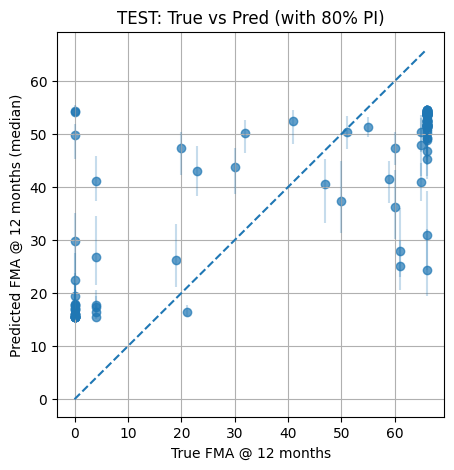

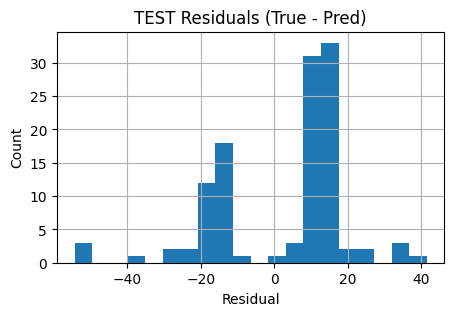


🧾 Example TEST patient:
  True FMA @ 12m : 66.0
  Pred FMA @ 12m : 46.72
  80% PI         : [42.13999938964844, 51.220001220703125]


In [ ]:
# ============================================================
# Cell 8) Plots (Test set) and Example Patient
#  - Scatter true vs predicted with vertical PI bars
#  - Residual histogram
#  - Text summary for one test patient
# ============================================================

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_med, alpha=0.7)
mx = max(np.max(y_test), np.max(y_test_med))
mn = min(np.min(y_test), np.min(y_test_med))
plt.plot([mn, mx],[mn, mx], linestyle="--")
for i in range(len(y_test)):
    # Vertical line for prediction interval
    plt.vlines(y_test[i], y_test_lo[i], y_test_hi[i], alpha=0.25)
plt.xlabel("True FMA @ 12 months")
plt.ylabel("Predicted FMA @ 12 months (median)")
plt.title("TEST: True vs Pred (with 80% PI)")
plt.grid(True)
plt.show()

plt.figure(figsize=(5,3))
resid = y_test - y_test_med
plt.hist(resid, bins=20)
plt.title("TEST Residuals (True - Pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Example patient from TEST set
sample_idx = 0
true_val = y_test[sample_idx]
pred_med = y_test_med[sample_idx]
pred_lo  = y_test_lo[sample_idx]
pred_hi  = y_test_hi[sample_idx]

print("\n🧾 Example TEST patient:")
print("  True FMA @ 12m :", round(true_val,2))
print("  Pred FMA @ 12m :", round(pred_med,2))
print("  80% PI         :", f"[{round(pred_lo,2)}, {round(pred_hi,2)}]")


In [ ]:
# ============================================================
# Cell 9) Save CSV (Per-patient predictions on TEST)
#  - Saves patient_id, truth, median prediction, and PI bounds
# ============================================================

out = pd.DataFrame({
    "patient_id": df.iloc[test_idx][pid_col].values,
    "y_true_12m": y_test,
    "y_pred_med": y_test_med,
    "y_pi_lo": y_test_lo,
    "y_pi_hi": y_test_hi
})
out_path = "fma12m_predictions_test.csv"
out.to_csv(out_path, index=False)
print(f"💾 Saved: {out_path}")


💾 Saved: fma12m_predictions_test.csv


In [ ]:
# ============================================================
# Optional Cell 10) Train a "No-6m" variant (7d + 3m only)
#  - Useful if 6m data is not always available in practice
# ============================================================

# Build a reduced feature set (exclude 6m and its derivatives)
reduced_remove = {colmap["fma_6m"], "d_3to6", "slope_3to6_perday", "recovery_ratio_6m"}
reduced_cols = [c for c in X_cols if c not in reduced_remove]

Xr = df[reduced_cols].copy()
yr = df[y_col].values
gr = df[pid_col].astype(str).values

# Split again (group-safe)
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=RANDOM_STATE)
tr_idx, test_idx = next(gss_outer.split(Xr, yr, gr))
Xr_train, yr_train, gr_train = Xr.iloc[tr_idx], yr[tr_idx], gr[tr_idx]
Xr_test,  yr_test,  gr_test  = Xr.iloc[test_idx], yr[test_idx], gr[test_idx]
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.1765, random_state=RANDOM_STATE)
ix_tr, ix_val = next(gss_inner.split(Xr_train, yr_train, gr_train))
Xr_tr, yr_tr, gr_tr = Xr_train.iloc[ix_tr], yr_train[ix_tr], gr_train[ix_tr]
Xr_val, yr_val, gr_val = Xr_train.iloc[ix_val], yr_train[ix_val], gr_train[ix_val]

# Build preprocess for reduced feature space
cat_cols_r = [c for c in cat_cols if c in reduced_cols]
num_cols_r = [c for c in reduced_cols if c not in cat_cols_r]

numeric_transformer_r = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])
try:
    ohe_r = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_r = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer_r = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe_r)
])

preprocess_r = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_r, num_cols_r),
        ("cat", categorical_transformer_r, cat_cols_r),
    ],
    remainder="drop"
)

pipe_r = Pipeline([
    ("pp", preprocess_r),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=500,
        tree_method="hist",
        device="auto"
    )),
])

rand_r = RandomizedSearchCV(
    estimator=pipe_r,
    param_distributions={f"xgb__{k}": v for k,v in param_dist.items()},
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=list(GroupKFold(n_splits=5).split(Xr_tr, yr_tr, gr_tr)),
    verbose=0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rand_r.fit(Xr_tr, yr_tr)

print("🏁 [No-6m] Best params:")
for k,v in rand_r.best_params_.items():
    print(" ", k, ":", v)

y_val_pred_r = rand_r.best_estimator_.predict(Xr_val)
print("\n🔎 [No-6m] VALID metrics")
print("  MAE   :", mean_absolute_error(yr_val, y_val_pred_r))
print("  MedAE :", median_absolute_error(yr_val, y_val_pred_r))
print("  RMSE  :", np.sqrt(np.mean((yr_val - y_val_pred_r)**2)))
print("  R²    :", r2_score(yr_val, y_val_pred_r))


ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:17] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7dae5402dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7dae541deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7dae541e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7dae543c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7dae543cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7dae53f3742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7dae77ec1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7dae77ebe493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7dae77edf8c1]



--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:17] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7e729822dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7e72983deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7e72983e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7e72985c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7e72985cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7e729813742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e72bbf14e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e72bbf11493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7e72bbf328c1]



--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:18] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7dae5402dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7dae541deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7dae541e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7dae543c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7dae543cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7dae53f3742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7dae77ec1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7dae77ebe493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7dae77edf8c1]



--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:18] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7e729822dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7e72983deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7e72983e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7e72985c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7e72985cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7e729813742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e72bbf14e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e72bbf11493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7e72bbf328c1]



--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:19] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7dae5402dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7dae541deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7dae541e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7dae543c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7dae543cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7dae53f3742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7dae77ec1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7dae77ebe493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7dae77edf8c1]



--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:19] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7e729822dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7e72983deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7e72983e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7e72985c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7e72985cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7e729813742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e72bbf14e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e72bbf11493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7e72bbf328c1]



--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:20] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7dae5402dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7dae541deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7dae541e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7dae543c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7dae543cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7dae53f3742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7dae77ec1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7dae77ebe493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7dae77edf8c1]



--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 2100, in update
    _check_call(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [18:10:20] /workspace/src/context.cc:101: Invalid argument for `device`. Expected to be one of the following:
- cpu
- cuda
- cuda:<device ordinal>  # e.g. cuda:0
- gpu
- gpu:<device ordinal>   # e.g. gpu:0
Got: `auto`.
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7e729822dbbc]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3deace) [0x7e72983deace]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x3e13da) [0x7e72983e13da]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5c8ed2) [0x7e72985c8ed2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x5cabbd) [0x7e72985cabbd]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7e729813742f]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e72bbf14e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e72bbf11493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7e72bbf328c1]


